In [1]:
import random
import os
import numpy as np
from work.dataset.activitynet import ActivityNetDataset

dataset = ActivityNetDataset(
    videos_path='../../../../../dataset/videos.json',
    labels_path='../../../../../dataset/labels.txt'
)
videos = dataset.get_subset_videos('validation')
videos = random.sample(videos, 8)

examples = []
for v in videos:
    file_dir = os.path.join('../../../../../downloads/features/', v.features_file_name)
    if not os.path.isfile(file_dir):
        os.system('scp imatge:~/work/datasets/ActivityNet/v1.3/features/{} ../../../../../downloads/features/'.format(v.features_file_name))
    features = np.load(file_dir)
    examples.append((v, features))

In [2]:
from keras.layers import LSTM, BatchNormalization, Dense, Dropout, Input, TimeDistributed
from keras.models import Model

print('Compiling model')
input_video_features = Input(batch_shape=(1, 20, 4096,),
    name='video_features')
video_normalized = BatchNormalization(name='video_features_normalization')(input_video_features)
# input_mfcc_features = Input(batch_shape=(batch_size, timesteps, mfcc_size,),
#     name='mfcc_features')
# mfcc_normalized = BatchNormalization(name='mfcc_features_normalization')(input_mfcc_features)
# input_spec_features = Input(batch_shape=(batch_size, timesteps, spec_size,),
#     name='spec_features')
# spec_normalized = BatchNormalization(name='spec_features_normalization')(input_spec_features)
# input_merged_features = merge([video_normalized, mfcc_normalized, spec_normalized], mode='concat')
input_dropout = Dropout(p=.5)(video_normalized)
lstm = LSTM(512, return_sequences=False, stateful=True, name='lstm1')(input_dropout)

detection = Dense(201, activation='sigmoid', name='activity_detection')(lstm)

model = Model(input=input_video_features, output=detection)
model.load_weights('../model_snapshot/lstm_activity_detection_windows_01_e100.hdf5')
model.summary()
model.compile(loss='binary_crossentropy', optimizer='rmsprop')
print('Model Compiled!')

Using Theano backend.


Compiling model
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
video_features (InputLayer)      (1, 20, 4096)         0                                            
____________________________________________________________________________________________________
video_features_normalization (Bat(1, 20, 4096)         8192        video_features[0][0]             
____________________________________________________________________________________________________
dropout_1 (Dropout)              (1, 20, 4096)         0           video_features_normalization[0][0
____________________________________________________________________________________________________
lstm1 (LSTM)                     (1, 512)              9439232     dropout_1[0][0]                  
___________________________________________________________________________

In [3]:
timesteps = 20
overlap = .5

predictions = []
for v, features in examples:
    nb_instances = features.shape[0]
    nb_seq = np.ceil(np.array(nb_instances, dtype=np.float32) / (timesteps*overlap)).astype(np.int64) - 1
    if nb_instances < 20:
        nb_repetitions = np.ceil(float(timesteps)/nb_instances).astype(np.int64)
        vid_features = np.tile(features, (nb_repetitions, 1))[-timesteps:]
        nb_seq = 1
    else:
        vid_features = features
        
    index = np.zeros((nb_seq, timesteps)).astype(np.int64)
    for i in range(nb_seq):
        s = i * timesteps * overlap
        index[i,:] = np.arange(s, s+timesteps)
    assert index[-1,-1] >= (nb_instances - 1), 'index[-1,-1] = {} and instances: {}'.format(index[-1,-1], nb_instances)
    dif = index[-1,-1] - nb_instances + 1
    index[-1,:] -= dif
    
    X = features[index]
    
    model.reset_states()
    Y = model.predict(X, batch_size=1)
    
    prediction = np.zeros((nb_instances, 201))
    for i in range(nb_seq):
        prediction[index[i]] += Y[i]
    prediction /= np.repeat(np.bincount(index.reshape((-1))).reshape((-1,1)), 201, axis=1)
        
    class_prediction = np.argmax(prediction, axis=1)
    predictions.append((v, prediction, class_prediction))


Video ID: 1y2aqd5HQlU		Ground truth: Carving jack-o-lanterns
0.2350	Carving jack-o-lanterns
0.1742	Wrapping presents
0.0541	Sharpening knives


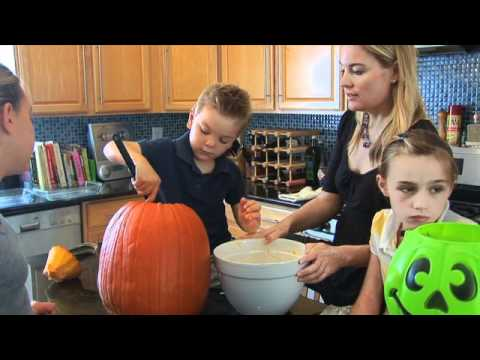



Video ID: hfZQBDePOOE		Ground truth: Wakeboarding
0.5878	Wakeboarding
0.3832	Waterskiing
0.0073	Surfing


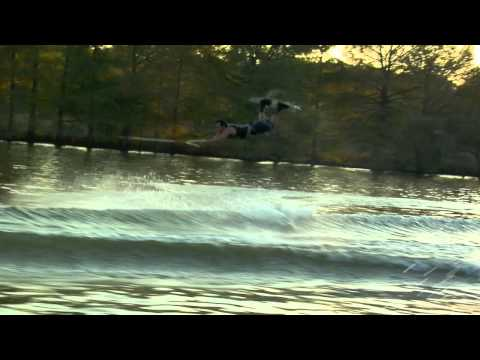



Video ID: zqcJ0N_a6y8		Ground truth: Tug of war
0.3131	Paintball
0.1427	Blowing leaves
0.0556	Starting a campfire


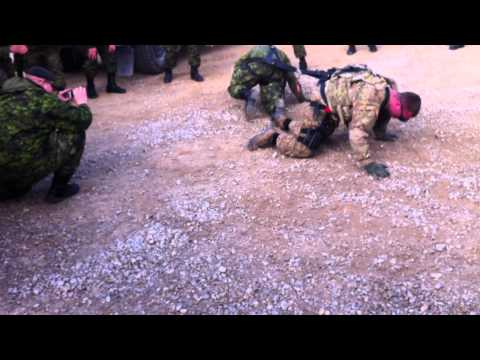



Video ID: jFZRNe7xFY8		Ground truth: Using the balance beam
0.6675	Tumbling
0.1800	Using the balance beam
0.0460	Using the pommel horse


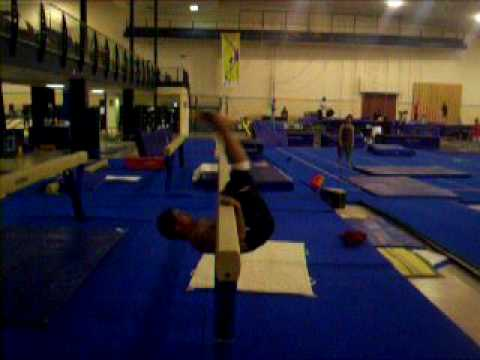



Video ID: ULH_AqrP3to		Ground truth: Mooping floor
0.0926	Wrapping presents
0.0716	Waxing skis
0.0715	Ironing clothes


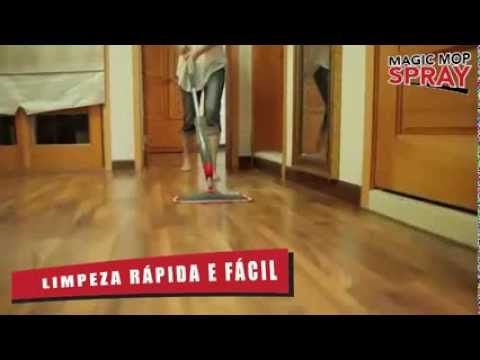



Video ID: eYgXvnnlPQA		Ground truth: Rock climbing
0.7119	Rock climbing
0.0569	Fixing the roof
0.0170	Bungee jumping


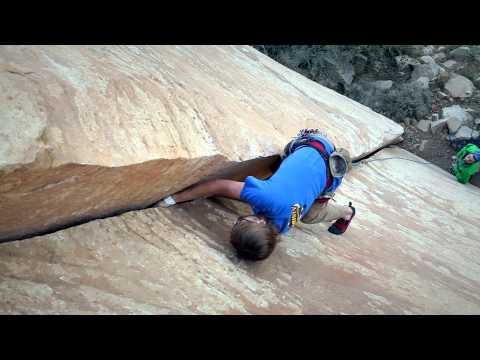



Video ID: W6JJ1L_EEBY		Ground truth: BMX
0.8119	BMX
0.0454	Pole vault
0.0162	Tumbling


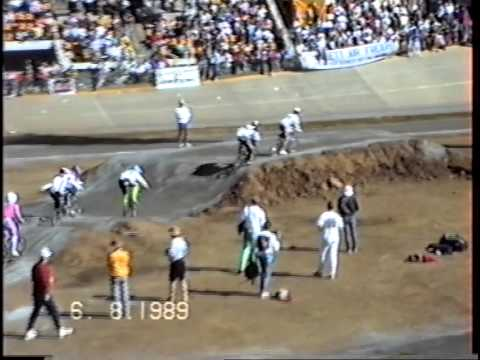



Video ID: ufBz1xfqQoM		Ground truth: Tango
0.6444	Tango
0.0442	Belly dance
0.0223	Cumbia


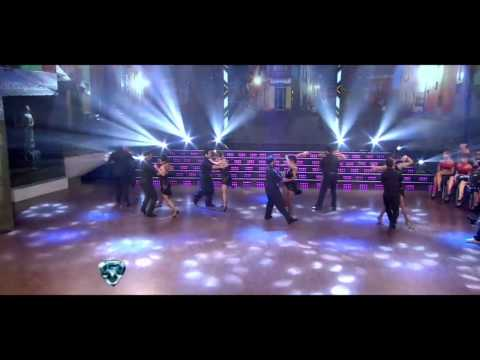

In [4]:
from IPython.display import YouTubeVideo, display

for v, prediction, class_prediction in predictions:
    print('Video ID: {}\t\tGround truth: {}'.format(v.video_id, v.get_activity()))
    class_means = np.mean(prediction, axis=0)
    top_3 = np.argsort(class_means[1:])[::-1][:3] + 1
    scores = class_means[top_3]/np.sum(class_means[1:])
    for index, score in zip(top_3, scores):
        if score == 0.:
            continue
        label = dataset.labels[index][1]
        print('{:.4f}\t{}'.format(score, label))
    vid = YouTubeVideo(v.video_id)
    display(vid)
    print('\n')

Video ID: 1y2aqd5HQlU
Main Activity: Carving jack-o-lanterns
0.2350	Carving jack-o-lanterns
0.1742	Wrapping presents
0.0541	Sharpening knives


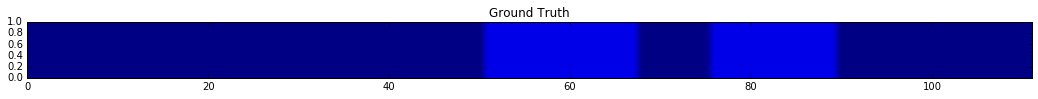

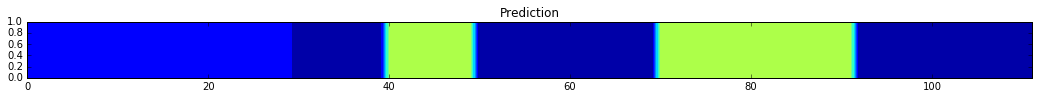



Video ID: hfZQBDePOOE
Main Activity: Wakeboarding
0.5878	Wakeboarding
0.3832	Waterskiing
0.0073	Surfing


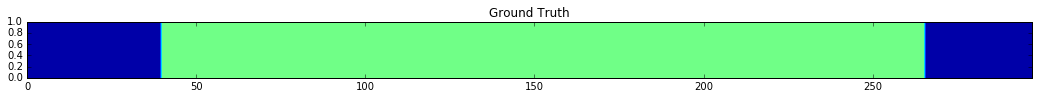

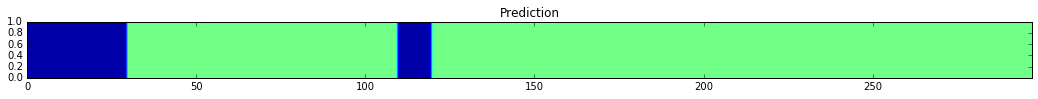



Video ID: zqcJ0N_a6y8
Main Activity: Tug of war
0.3131	Paintball
0.1427	Blowing leaves
0.0556	Starting a campfire


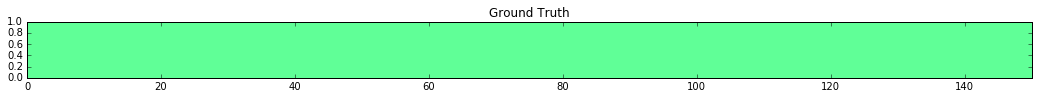

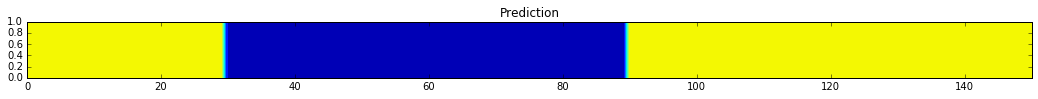



Video ID: jFZRNe7xFY8
Main Activity: Using the balance beam
0.6675	Tumbling
0.1800	Using the balance beam
0.0460	Using the pommel horse


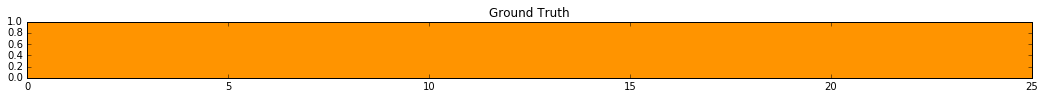

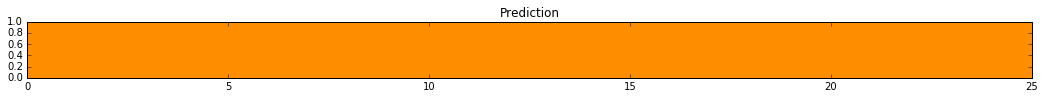



Video ID: ULH_AqrP3to
Main Activity: Mooping floor
0.0926	Wrapping presents
0.0716	Waxing skis
0.0715	Ironing clothes


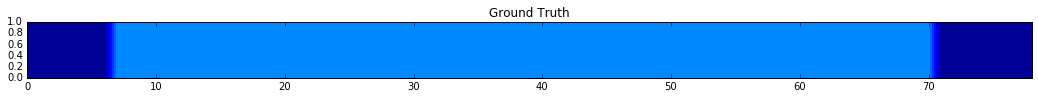

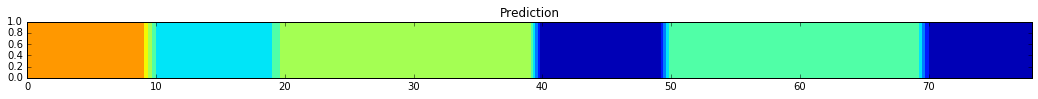



Video ID: eYgXvnnlPQA
Main Activity: Rock climbing
0.7119	Rock climbing
0.0569	Fixing the roof
0.0170	Bungee jumping


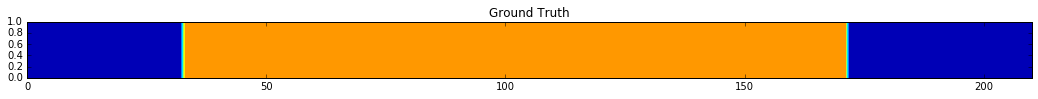

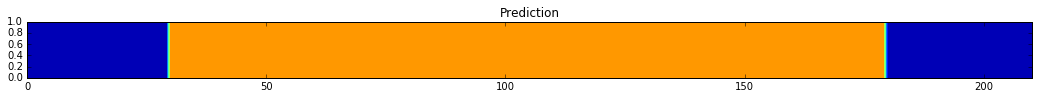



Video ID: W6JJ1L_EEBY
Main Activity: BMX
0.8119	BMX
0.0454	Pole vault
0.0162	Tumbling


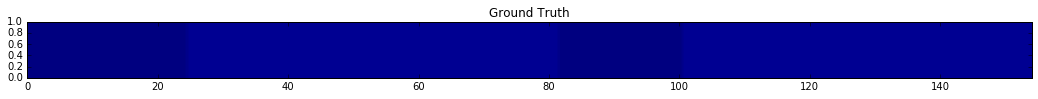

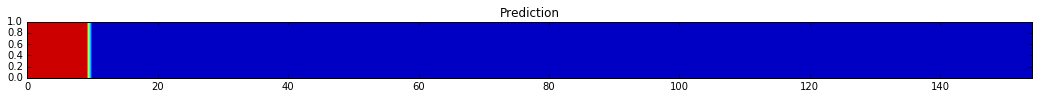



Video ID: ufBz1xfqQoM
Main Activity: Tango
0.6444	Tango
0.0442	Belly dance
0.0223	Cumbia


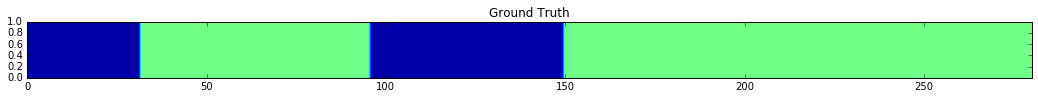

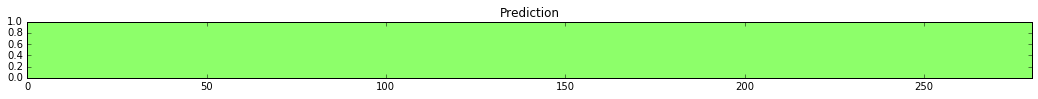

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
normalize = matplotlib.colors.Normalize(vmin=0, vmax=201)

for v, prediction, class_prediction in predictions:
    v.get_video_instances(16, 0)
    ground_truth = np.array([instance.output for instance in v.instances])
    nb_instances = len(v.instances)
    
    print('Video ID: {}\nMain Activity: {}'.format(v.video_id, v.get_activity()))
    class_means = np.mean(prediction, axis=0)
    top_3 = np.argsort(class_means[1:])[::-1][:3] + 1
    scores = class_means[top_3]/np.sum(class_means[1:])
    for index, score in zip(top_3, scores):
        if score == 0.:
            continue
        label = dataset.labels[index][1]
        print('{:.4f}\t{}'.format(score, label))
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(ground_truth, (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Ground Truth')
    plt.show()
    
    # recompute class prediction
    activity_prob = np.sum(prediction[:,1:], axis=1)
    class_prediction[activity_prob>0.3] = np.argmax(prediction[activity_prob>.3,1:], axis=1) + 1
    plt.figure(num=None, figsize=(18, 1), dpi=100)
    plt.contourf(np.broadcast_to(class_prediction, (2, nb_instances)), norm=normalize, interpolation='nearest')
    plt.title('Prediction')
    plt.show()

    print('\n')